In [ ]:
import pandas as pd

fights_sorted = pd.read_csv('enhanced_fights.csv', parse_dates=['event_date'])

In [ ]:
import random

# convert text metrics into 'category'
for col in fights_sorted:
    if fights_sorted[col].dtypes == object:
        fights_sorted[col] = fights_sorted[col].astype('category')

def stance_repr(stance):
    match stance:
        case "Orthodox":
            return 0
        case "Southpaw":
            return 1
        case "Switch":
            return 3
        case _:
            return 4

def randomize_fighter_positions(fights):
    fights_copy = fights.copy()
    
    # randomized fighter names
    randomized_rows = []
    
    for _, row in fights_copy.iterrows():
        new_row = row.copy()
        
        if random.random() > 0.5:
            # Store original values
            f1_name = row['f1_name']
            f1_height = row['f1_height']
            f1_reach = row['f1_reach']
            f1_age = row['f1_age']
            f1_stance = row['f1_stance']
            f1_strikes = row['f1_strikes']
            f1_td = row['f1_td']
            f1_td_def = row['f1_td_def']
            
            # swap fighter 1 with fighter 2
            new_row['f1_name'] = row['f2_name']
            new_row['f1_height'] = row['f2_height']
            new_row['f1_reach'] = row['f2_reach']
            new_row['f1_age'] = row['f2_age']
            new_row['f1_stance'] = row['f2_stance']
            new_row['f1_strikes'] = row['f2_strikes']
            new_row['f1_td'] = row['f2_td']
            new_row['f1_td_def'] = row['f2_td_def']
            
            # swap fighter 2 with fighter 1
            new_row['f2_name'] = f1_name
            new_row['f2_height'] = f1_height
            new_row['f2_reach'] = f1_reach
            new_row['f2_age'] = f1_age
            new_row['f2_stance'] = f1_stance
            new_row['f2_strikes'] = f1_strikes
            new_row['f2_td'] = f1_td
            new_row['f2_td_def'] = f1_td_def
        
        randomized_rows.append(new_row)
    
    return pd.DataFrame(randomized_rows)

# create model data
def build_fighter_history(fights):
    rows = []

    for _, row in fights.iterrows():
        event_date = row['event_date']
        previous_fights = fights[fights['event_date'] < event_date]

        # fighter 1 stats from previous fights
        past_f1 = previous_fights[(previous_fights['f1_name'] == row['f1_name']) | (previous_fights['f2_name'] == row['f1_name'])]
        # fighter 2 stats from previous fights
        past_f2 = previous_fights[(previous_fights['f1_name'] == row['f2_name']) | (previous_fights['f2_name'] == row['f2_name'])]
        
        # only work with fighters with 3 or more fights in the UFC
        if len(past_f1) < 3 or len(past_f2) < 3:
            continue

        # fighter 1
        # strikes
        avg_f1_strikes = past_f1['f1_strikes'].mean()
        # takedowns
        avg_f1_td = past_f1['f1_td'].mean()
        avg_f1_td_def = past_f1['f1_td_def'].mean()
        avg_f1_td_rate = past_f1['f1_td_rate'].mean()
        avg_f1_td_def_rate = past_f1['f1_td_def_rate'].mean()
        # fight record
        f1_last = past_f1.head(1)[past_f1['winner'] == row['f1_name']].shape[0]
        f1_last_3 = past_f1.head(3)[past_f1['winner'] == row['f1_name']].shape[0] / 3
        f1_record = past_f1[past_f1['winner'] == row['f1_name']].shape[0] / past_f1.shape[0]
        f1_ko_loss = past_f1[(past_f1['winner'] != row['f1_name']) & (past_f1['method'] == 'KO/TKO')].shape[0]
        f1_ko_rate = past_f1[(past_f1['winner'] == row['f1_name']) & (past_f1['method'] == 'KO/TKO')].shape[0] / past_f1.shape[0]
        f1_already_beat = past_f1[(past_f1['winner'] == row['f1_name']) & (past_f1['loser'] == row['f2_name'])].shape[0]

        # fighter 2
        # strikes
        avg_f2_strikes = past_f2['f2_strikes'].mean()
        # takedowns
        avg_f2_td = past_f2['f2_td'].mean()
        avg_f2_td_def = past_f2['f2_td_def'].mean()
        avg_f2_td_rate = past_f2['f2_td_rate'].mean()
        avg_f2_td_def_rate = past_f2['f2_td_def_rate'].mean()
        # fight record
        f2_last = past_f2.head(1)[past_f2['winner'] == row['f2_name']].shape[0]
        f2_last_3 = past_f2.head(3)[past_f2['winner'] == row['f2_name']].shape[0] / 3
        f2_record = past_f2[past_f2['winner'] == row['f2_name']].shape[0] / past_f2.shape[0]
        f2_ko_loss = past_f2[(past_f2['winner'] != row['f2_name']) & (past_f2['method'] == 'KO/TKO')].shape[0]
        f2_ko_rate = past_f2[(past_f2['winner'] == row['f2_name']) & (past_f2['method'] == 'KO/TKO')].shape[0] / past_f2.shape[0]
        f2_already_beat = past_f2[(past_f2['winner'] == row['f2_name']) & (past_f2['loser'] == row['f1_name'])].shape[0]

        # Fighter 1
        rows.append({
            'fighter': row['f1_name'],
            # fighter metrics
            'strikes': avg_f1_strikes,
            'td': avg_f1_td,
            'td_def': avg_f1_td_def,
            'td_rate': avg_f1_td_rate,
            'td_def_rate': avg_f1_td_def_rate,
            'height': row['f1_height'],
            'reach': row['f1_reach'],
            'age': row['f1_age'],
            'stance': stance_repr(row['f1_stance']),
            # record
            'last' : f1_last,
            'last_3': f1_last_3,
            'record': f1_record,
            'ko_loss': f1_ko_loss,
            'ko_rate': f1_ko_rate,
            'already_beat': f1_already_beat,
            # oponent metrics
            'opp': row['f2_name'],
            'opp_strikes': avg_f2_strikes,
            'opp_td': avg_f2_td,
            'opp_td_def': avg_f2_td_def,
            'opp_td_rate': avg_f2_td_rate,
            'opp_td_def_rate': avg_f2_td_def_rate,
            'opp_height': row['f2_height'],
            'opp_reach': row['f2_reach'],
            'opp_age': row['f2_age'],
            'opp_stance': stance_repr(row['f2_stance']),
            # oponent record
            'opp_last' : f2_last,
            'opp_last_3': f2_last_3,
            'opp_record': f2_record,
            'opp_ko_loss': f2_ko_loss,
            'opp_ko_rate': f2_ko_rate,
            'opp_already_beat': f2_already_beat,
            # difference in metrics
            'age_diff': row['f1_age'] - row['f2_age'],
            'height_diff': row['f1_height'] - row['f2_height'],
            'reach_diff': row['f1_reach'] - row['f2_reach'],
            'strikes_diff': avg_f1_strikes - avg_f2_strikes,
            'stance_diff' : stance_repr(row['f1_stance']) - stance_repr(row['f2_stance']),
            'td_diff': avg_f1_td - avg_f2_td,
            'record_diff':f1_record - f2_record,
            'last_3_diff': f1_last_3 - f2_last_3,
            'won': 1 if row['winner'] == row['f1_name'] else 0,
            'event_date': row['event_date'],
        })

    return pd.DataFrame(rows)

fights_randomized = randomize_fighter_positions(fights_sorted)
model_data = build_fighter_history(fights_randomized)

# model_data.to_csv('model_data.csv', index=False)

/var/folders/20/srwc7kjs6f3cp69qjczdmtcm0000gn/T/ipykernel_39962/3569166344.py:91: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_last = past_f1.head(1)[past_f1['winner'] == row['f1_name']].shape[0]
/var/folders/20/srwc7kjs6f3cp69qjczdmtcm0000gn/T/ipykernel_39962/3569166344.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_last_3 = past_f1.head(3)[past_f1['winner'] == row['f1_name']].shape[0] / 3
/var/folders/20/srwc7kjs6f3cp69qjczdmtcm0000gn/T/ipykernel_39962/3569166344.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f2_last = past_f2.head(1)[past_f2['winner'] == row['f2_name']].shape[0]
/var/folders/20/srwc7kjs6f3cp69qjczdmtcm0000gn/T/ipykernel_39962/3569166344.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f2_last_3 = past_f2.head(3)[past_f2['winner'] == row['f2_name']].shape[0] / 3
/var/folders/20/srwc7kjs6f3cp69qjczdmtcm0000gn/T/ipyke

          fighter  strikes        td  td_def  td_rate  td_def_rate  height  \
3550  evan tanner     11.0  0.666667     0.0      1.0          0.0    72.0   

      reach   age  stance  ...  age_diff  height_diff  reach_diff  \
3550   74.0  30.0       0  ...       4.0         -3.0         0.0   

      strikes_diff  stance_diff   td_diff record_diff  last_3_diff  won  \
3550     -3.142857            0 -0.333333    0.285714     0.333333    0   

      event_date  
3550  2001-02-23  

[1 rows x 42 columns]
Test accuracy: 55.80%
ROC AUC: 0.5580


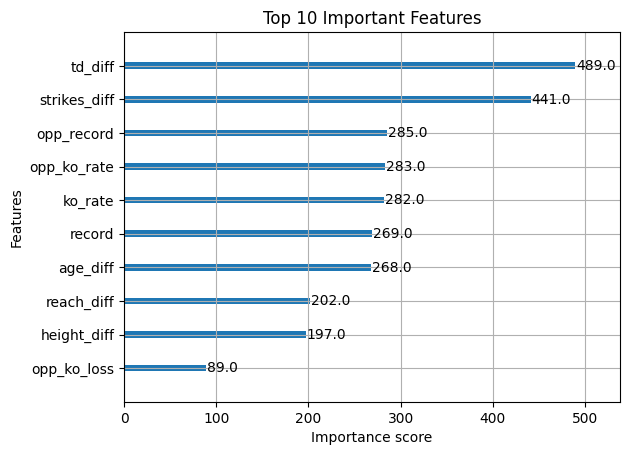

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# df = pd.read_csv('model_data.csv')
df = model_data.copy()

# drop missing data
df = df.dropna()

# features
features = [
    # strikes
    # 'strikes',
    # takedown
    # 'td',
    # 'td_def',
    # 'td_rate',
    # 'td_def_rate',
    # metrics
    # 'height',
    # 'reach',
    # 'age',
    # 'stance',
    # record
    'last',
    'last_3',
    'record',
    'ko_loss',
    'ko_rate',
    # 'already_beat',
    # opponent strikes
    # 'opp_strikes',
    # oponent takedowns
    # 'opp_td',
    # 'opp_td_def',
    # 'opp_td_rate',
    # 'opp_td_def_rate',
    # oponent metrics
    # 'opp_height',
    # 'opp_reach',
    # 'opp_age',
    # 'opp_stance',
    # opponent record
    'opp_last',
    'opp_last_3',
    'opp_record',
    'opp_ko_loss',
    'opp_ko_rate',
    # 'opp_already_beat',
    # differentials
    'age_diff', 'strikes_diff', 'td_diff', 'reach_diff', 'height_diff',
]

label = 'won'

# start with oldest now
df = df.sort_values('event_date', ascending=True)
print(df.head(1))

#  80% train, 20% test
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]


# get train / test data
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df['won'], test_size=0.2, stratify=df['won'], random_state=42
)
# create model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
)
model.fit(X_train, y_train)

# use model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2%}")
print(f"ROC AUC: {roc_auc:.4f}")
# get feature data
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()

# Test accuracy: 55.80%
# ROC AUC: 0.5580

[0]	validation_0-auc:0.57843	validation_1-auc:0.58719
[1]	validation_0-auc:0.61038	validation_1-auc:0.62741
[2]	validation_0-auc:0.62091	validation_1-auc:0.63025
[3]	validation_0-auc:0.62953	validation_1-auc:0.63385
[4]	validation_0-auc:0.63824	validation_1-auc:0.62980
[5]	validation_0-auc:0.64190	validation_1-auc:0.62721
[6]	validation_0-auc:0.64044	validation_1-auc:0.62778
[7]	validation_0-auc:0.64286	validation_1-auc:0.62909
[8]	validation_0-auc:0.64263	validation_1-auc:0.63254
[9]	validation_0-auc:0.64690	validation_1-auc:0.63738
[10]	validation_0-auc:0.64759	validation_1-auc:0.63682
[11]	validation_0-auc:0.64648	validation_1-auc:0.63738
[12]	validation_0-auc:0.65060	validation_1-auc:0.63774
[13]	validation_0-auc:0.65287	validation_1-auc:0.63999
[14]	validation_0-auc:0.65292	validation_1-auc:0.63917
[15]	validation_0-auc:0.65319	validation_1-auc:0.64035
[16]	validation_0-auc:0.65505	validation_1-auc:0.64195
[17]	validation_0-auc:0.65628	validation_1-auc:0.64121
[18]	validation_0-au

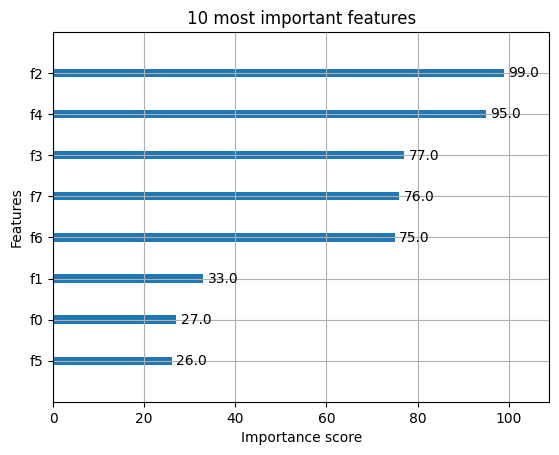

In [154]:
from sklearn.preprocessing import StandardScaler

# df = pd.read_csv('model_data.csv')
df = model_data.copy()

# drop missing data
df = df.dropna()

# 80% train 20% test
split_date = df['event_date'].quantile(0.8)
train = df[df['event_date'] <= split_date]
test = df[df['event_date'] > split_date]

# features
features = [
    'height_diff', 'reach_diff', 'age_diff',
    'strikes_diff', 'td_diff', 'last_3_diff', # 'stance_diff',
    # 'last_3', 'opp_last_3',
    'record', 'opp_record'
]

label = 'won'

X_train = train[features]
y_train = train[label]
X_test = test[features]
y_test = test[label]

# scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=3,
    learning_rate=0.01,
    n_estimators=1000,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=0.5,
    early_stopping_rounds=20,
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
)

# predictions
y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("10 most important features")
plt.show()

# Accuracy: 0.6139
# ROC AUC: 0.6475

In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

df = model_data.copy()

# drop missing data
df = df.dropna()

# 80% train 20% test
split_date = df['event_date'].quantile(0.8)
train = df[df['event_date'] <= split_date]
test = df[df['event_date'] > split_date]

# features
features = [
    'height_diff', 'reach_diff', 'age_diff',
    'strikes_diff', 'td_diff', 'last_3_diff',
    'record', 'opp_record'
]

label = 'won'

X_train = train[features]
y_train = train[label]
X_test = test[features]
y_test = test[label]

forest_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=5
)

forest_model.fit(X_train, y_train)
preds = forest_model.predict(X_test)
pred_probs = forest_model.predict_proba(X_test)[:, 1]

# Evaluate properly
print("Accuracy:", accuracy_score(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, pred_probs))

# no leaks (future data included)
assert test['event_date'].min() > train['event_date'].max()

# Accuracy: 0.6093514328808446
# ROC AUC: 0.6463254832016889

Accuracy: 0.6093514328808446
ROC AUC: 0.6463254832016889


In [157]:
import joblib

# xgboost model
xgb_model.save_model("xgboost_model.json")
# random forest model
joblib.dump(forest_model, "random_forest.joblib")

['random_forest.joblib']